# Import Toolkits

In [36]:
import os
import random
from shutil import copy2
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets , transforms
from tqdm.notebook import tqdm

In [3]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)

!python --version

torch version :  2.6.0+cu124
torchvision version :  0.21.0+cu124
numpy version :  1.26.4
Python 3.11.11


# Exploring our data

In [4]:
df = pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")
df.sample(10)

image_id  label
19131   572739477.jpg      3
5323   1949374159.jpg      1
14305  3558082230.jpg      3
15027  3699200152.jpg      3
3448   1604328731.jpg      1
9765   2732825636.jpg      1
2129   1369732079.jpg      3
10012  2780944471.jpg      3
10651  2898656244.jpg      4
2698   1469167700.jpg      4

In [5]:
label_map = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

In [6]:
data_dir = "/kaggle/input/cassava-leaf-disease-classification"

In [7]:
train_dir = os.path.join(data_dir , "train_images")
train_dir

'/kaggle/input/cassava-leaf-disease-classification/train_images'

In [8]:
output_path = os.path.join("/kaggle/working/" , "train")
for label in df['label'].unique():
    class_name = label_map[label]
    class_dir = os.path.join(output_path , class_name)
    os.makedirs(class_dir , exist_ok = True)

In [9]:
for _ , row in df.iterrows():
    filename = row['image_id']
    label = row['label']
    class_name = label_map[label]

    src_path = os.path.join(train_dir , filename)
    dst_path = os.path.join(output_path , class_name , filename)

    shutil.copy(src_path , dst_path)

In [10]:
classes = os.listdir(output_path)
classes

['Healthy',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Bacterial Blight (CBB)',
 'Cassava Mosaic Disease (CMD)',
 'Cassava Green Mottle (CGM)']

Let's look at a few examples of each class

In [11]:
def sample_images(data_path , class_name):

    class_dir = os.path.join(data_path , class_name)
    
    if not os.path.exists(class_dir):
        return "Invalid directory"
        
    images_list = os.listdir(class_dir)

    random_imgs = random.sample(images_list , 4)

    #plot
    plt.figure(figsize = (20,20))
    
    for i in range(4):
        
        img_loc = os.path.join(class_dir , random_imgs[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1,4,i + 1)
        plt.imshow(img)
        plt.axis("off")

First, let's look at some healthy plants.

In [12]:
classes

['Healthy',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Bacterial Blight (CBB)',
 'Cassava Mosaic Disease (CMD)',
 'Cassava Green Mottle (CGM)']

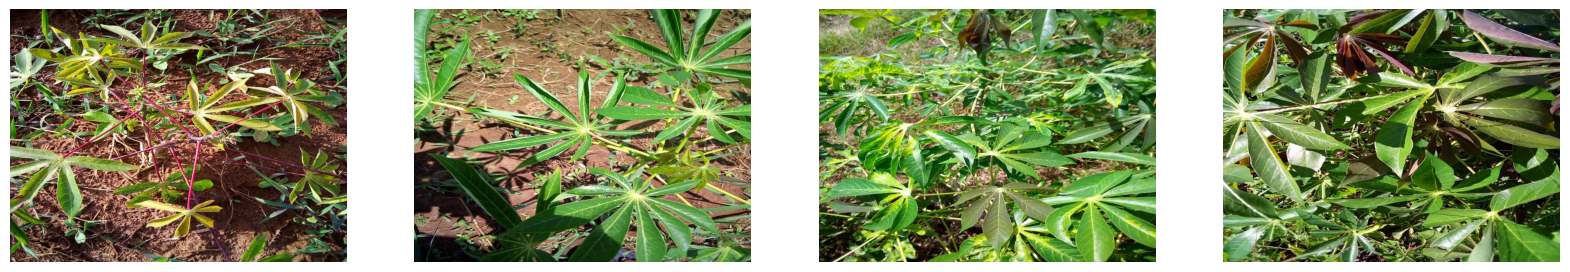

In [13]:
sample_images(output_path , classes[0])

let`s look at examples of the first disease class (green mottle virus).

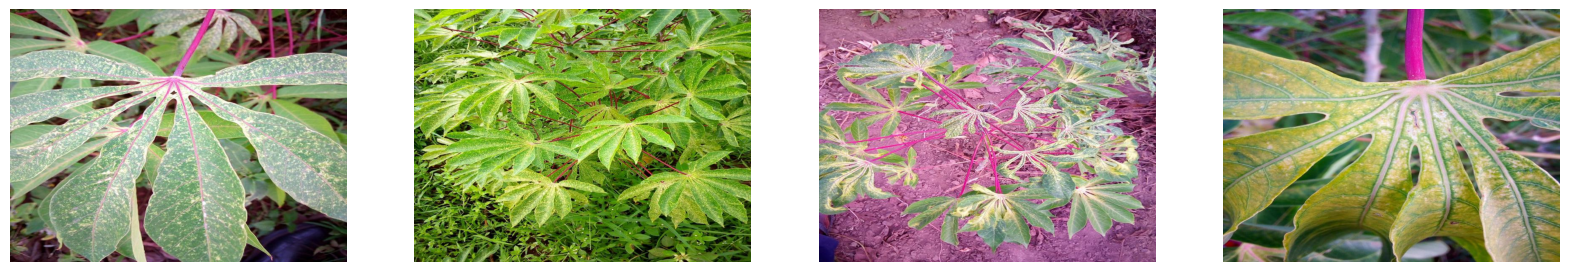

In [14]:
sample_images(output_path , classes[4])

let`s look at examples of the second disease class (bacterial blight).

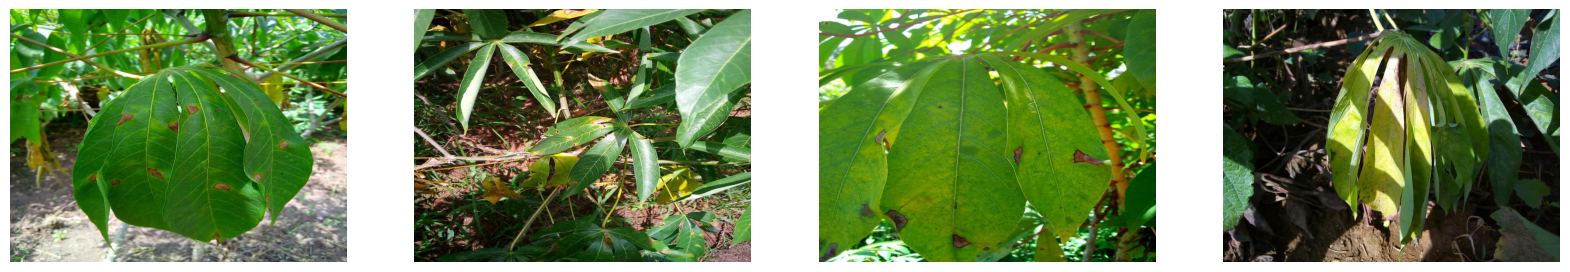

In [15]:
sample_images(output_path , classes[2])

let`s look at examples of the third disease class (brown streak disease).

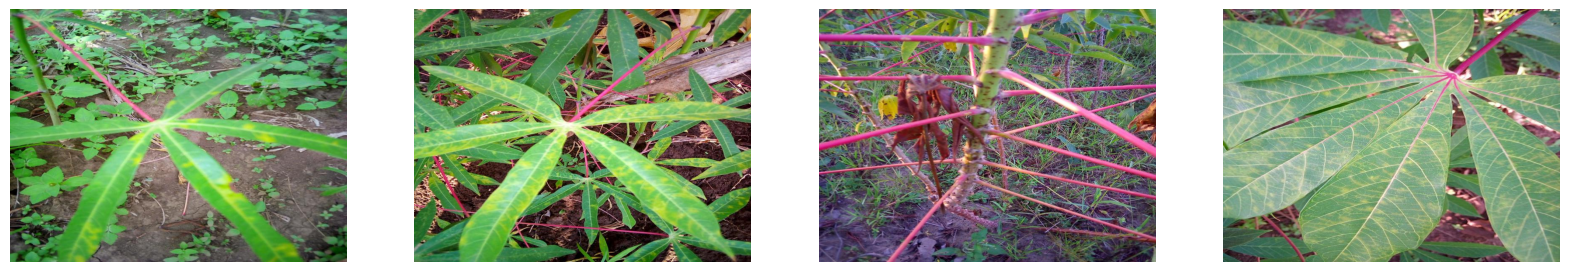

In [16]:
sample_images(output_path , classes[1])

let`s look at examples of the fourth disease class (mosaic disease).

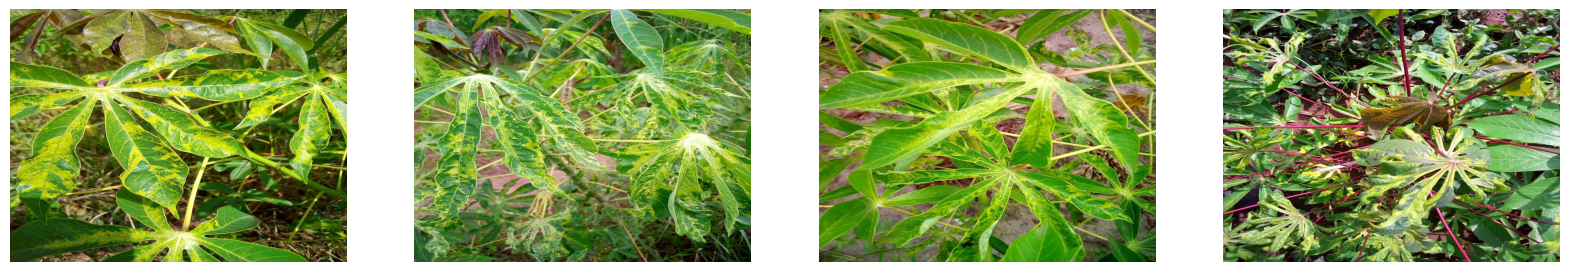

In [17]:
sample_images(output_path , classes[3])

# Preparing Our Data

In [18]:
class ConvertToRGB(object):
    def __call__(self , img):
        if img.mode != "RGB":
            img =img.convert("RGB")
        return img

In [19]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]
)

In [20]:
batch_size = 32
dataset = datasets.ImageFolder(root = output_path , transform = transform_basic)
dataset_loader = DataLoader(dataset = dataset , batch_size = batch_size)
batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


# Normalized Data

In [21]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum , channels_squared_sum , num_batches = 0 , 0 , 0
    
    for data , _ in tqdm(loader , desc = "Computing mean and std" , leave = True):
        channels_sum += torch.mean(data , dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2 , dim= [0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean , std

In [22]:
mean , std = get_mean_std(dataset_loader)
print(f"Mean = {mean}")
print(f"Standard deviation = {std}")

Computing mean and std:   0%|          | 0/669 [00:00<?, ?it/s]

Mean = tensor([0.4303, 0.4968, 0.3134])
Standard deviation = tensor([0.2206, 0.2236, 0.2118])


In [23]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean , std = std)
    ]
)

In [24]:
norm_dataset = datasets.ImageFolder(root = output_path , transform = transform_norm)
norm_loader = DataLoader(dataset = norm_dataset , batch_size = batch_size)
batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape", batch_shape)

Getting batches of shape torch.Size([32, 3, 224, 224])


In [25]:
norm_mean , norm_std = get_mean_std(norm_loader)
print(f"Mean = {norm_mean}")
print(f"Standard deviation = {norm_std}")

Computing mean and std:   0%|          | 0/669 [00:00<?, ?it/s]

Mean = tensor([ 1.3757e-06, -7.2866e-07, -7.5998e-08])
Standard deviation = tensor([1.0000, 1.0000, 1.0000])


# Train-Validation Split

In [26]:
train_dataset , val_dataset = random_split(norm_dataset , [0.8,0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)

percent_train = np.round(length_train * 100 / length_dataset , 2)
percent_val = np.round(length_val * 100 / length_dataset , 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [54]:
def class_count(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    try:
        class_to_index = dataset.class_to_idx
    except AttributeError:
        class_to_index = dataset.dataset.class_to_idx

    return pd.Series({cat: c[idx] for cat , idx in class_to_index.items()})

In [32]:
train_counts = class_count(train_dataset)
train_counts

  0%|          | 0/17118 [00:00<?, ?it/s]

Cassava Bacterial Blight (CBB)           864
Cassava Brown Streak Disease (CBSD)     1711
Cassava Green Mottle (CGM)              1901
Cassava Mosaic Disease (CMD)           10579
Healthy                                 2063
dtype: int64

<Axes: >

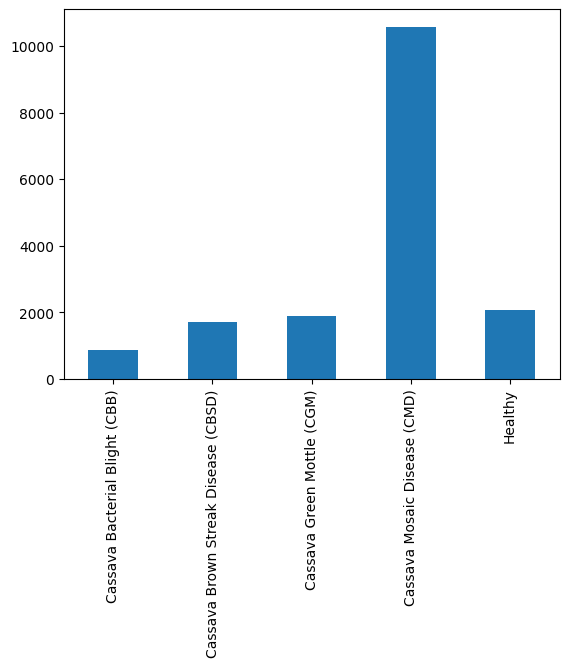

In [33]:
train_counts.plot(kind="bar")

In [34]:
val_counts = class_count(val_dataset)
val_counts

  0%|          | 0/4279 [00:00<?, ?it/s]

Cassava Bacterial Blight (CBB)          223
Cassava Brown Streak Disease (CBSD)     478
Cassava Green Mottle (CGM)              485
Cassava Mosaic Disease (CMD)           2579
Healthy                                 514
dtype: int64

<Axes: >

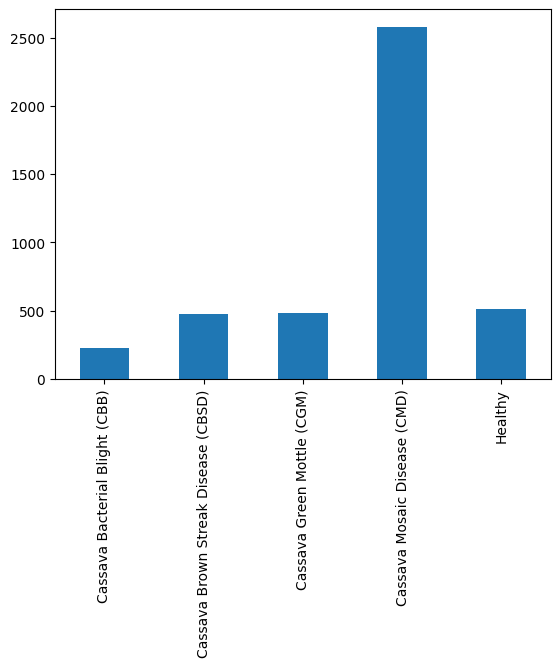

In [35]:
val_counts.plot(kind= "bar")

# Unbalanced Classes

In [37]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):
    """
    Undersample the dataset to have a uniform distribution across classes.

    Parameters:
    - dataset_dir: Path to the directory containing the class folders.
    - output_dir: Path to the directory where the undersampled dataset will be stored.
    - target_count: Number of instances to keep in each class. If None, the class with the least instances will set the target.
    """
    # Mapping each class to its files
    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files

    # Determine the minimum class size if target_count is not set
    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())

    # Creating the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Perform undersampling
    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Randomly select target_count images
        selected_files = random.sample(files, min(len(files), target_count))

        # Copy selected files to the output directory
        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

In [39]:
output_sampled_dir = os.path.join("/kaggle/working/" , "data_undersampled", "train")
print("Output directory:", output_sampled_dir)

Output directory: /kaggle/working/data_undersampled/train


In [41]:
undersample_dataset(output_path, output_sampled_dir)

Copying images for class Healthy


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava Brown Streak Disease (CBSD)


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava Bacterial Blight (CBB)


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava Mosaic Disease (CMD)


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class Cassava Green Mottle (CGM)


  0%|          | 0/1087 [00:00<?, ?it/s]

Undersampling completed. Each class has up to 1087 instances.


In [51]:
undersampled_dataset = datasets.ImageFolder(root = output_sampled_dir , transform= transform_norm)

In [49]:
undersampled_dataset.classes

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

In [55]:
undersample_counts = class_count(undersampled_dataset)

  0%|          | 0/5435 [00:00<?, ?it/s]

Cassava Bacterial Blight (CBB)         1087
Cassava Brown Streak Disease (CBSD)    1087
Cassava Green Mottle (CGM)             1087
Cassava Mosaic Disease (CMD)           1087
Healthy                                1087
dtype: int64


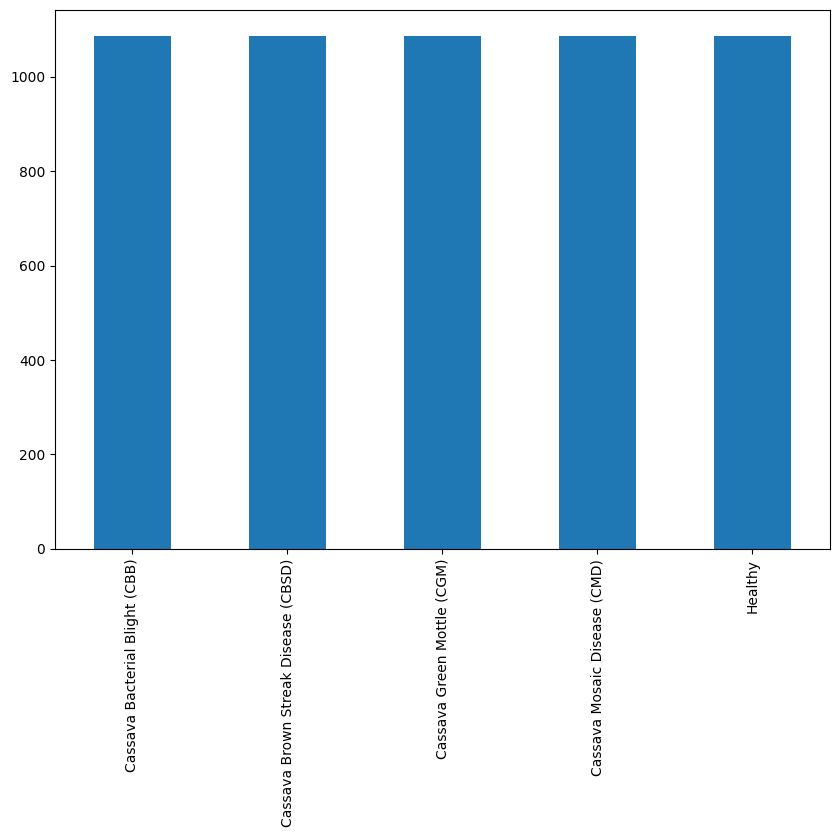

In [56]:
fig , ax = plt.subplots(figsize = (10,7))
print(undersample_counts)
undersample_counts.plot(kind = "bar" , ax=ax);